## Code to generate demand forecast

In [20]:
#import packages
import numpy as np
import pandas as pd
from datetime import datetime
# from statsmodels.tsa.arima_model import ARIMA
from pmdarima import arima, StepwiseContext
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import darts
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
# from darts.models import RNNModel
# from darts import TimeSeries
# from darts.utils.statistics import check_seasonality, plot_acf
# from darts.dataprocessing.transformers import Scaler
import xarray as xr
import itertools
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics

# Data pre-processing

In [5]:
#Add date parser to read in the date as an actual date object
date_parser = lambda x: datetime.strptime(x, '%d-%b-%Y')
demand = pd.read_csv('../data/ColumbiaDemand.csv', parse_dates=['Date'], date_parser=date_parser) 
demand.head()
#Restructure into one list of demands for each month

,Date,TotalDemand [kWh],Period01 [kWh],Period02 [kWh],Period03 [kWh],Period04 [kWh],Period05 [kWh],Period06 [kWh],Period07 [kWh],Period08 [kWh],...,Period87 [kWh],Period88 [kWh],Period89 [kWh],Period90 [kWh],Period91 [kWh],Period92 [kWh],Period93 [kWh],Period94 [kWh],Period95 [kWh],Period96 [kWh]
0,2018-01-01,72686.88,734.40,731.52,727.20,735.84,730.08,728.64,731.52,730.08,...,740.16,741.60,734.40,735.84,735.84,730.08,725.76,731.52,728.64,724.32
1,2018-01-02,73594.08,728.64,727.20,728.64,727.20,732.96,734.40,734.40,737.28,...,743.04,741.60,741.60,738.72,750.24,743.04,750.24,738.72,738.72,743.04
2,2018-01-03,73440.00,745.92,743.04,745.92,744.48,741.60,734.40,735.84,734.40,...,734.40,732.96,721.44,714.24,721.44,725.76,727.20,724.32,731.52,722.88
3,2018-01-04,73967.04,718.56,718.56,724.32,727.20,720.00,724.32,725.76,720.00,...,747.36,744.48,735.84,734.40,741.60,743.04,738.72,741.60,740.16,735.84
4,2018-01-05,74625.12,745.92,743.04,744.48,741.60,737.28,743.04,747.36,748.80,...,767.52,768.96,760.32,758.88,756.00,756.00,753.12,754.56,750.24,745.92


In [6]:
#Drop total demand columns and pivot
demand_unpivoted = demand[demand.columns.difference(['TotalDemand [kWh]'])].melt(id_vars=['Date'], var_name='period', value_name='demand')
#Make sure to sore by date and period
demand_unpivoted = demand_unpivoted.sort_values(by=['Date','period']).reset_index(drop=True)
demand_unpivoted['year'] = demand_unpivoted['Date'].apply(lambda x: x.year)
demand_unpivoted['month'] = demand_unpivoted['Date'].apply(lambda x: x.month)
demand_unpivoted['day'] = demand_unpivoted['Date'].apply(lambda x: x.day)
demand_unpivoted['period'] = demand_unpivoted['period'].apply(lambda x: (int(x.split()[0].split('d')[1])-1)*15)
demand_unpivoted['timestamp'] = demand_unpivoted['Date'] + pd.TimedeltaIndex(demand_unpivoted['period'], unit='m')
demand_unpivoted = demand_unpivoted.fillna(0)
demand_unpivoted.head() 

,Date,period,demand,year,month,day,timestamp
0,2018-01-01,0,734.40,2018,1,1,2018-01-01 00:00:00
1,2018-01-01,15,731.52,2018,1,1,2018-01-01 00:15:00
2,2018-01-01,30,727.20,2018,1,1,2018-01-01 00:30:00
3,2018-01-01,45,735.84,2018,1,1,2018-01-01 00:45:00
4,2018-01-01,60,730.08,2018,1,1,2018-01-01 01:00:00


In [7]:
demand_unpivoted.set_index('timestamp', inplace=True)

In [8]:
#split into train and test at 80% of the data
train = demand_unpivoted[0:int(len(demand_unpivoted)*.8)]['demand']
test = demand_unpivoted[int(len(demand_unpivoted)*.8):len(demand_unpivoted)]['demand']

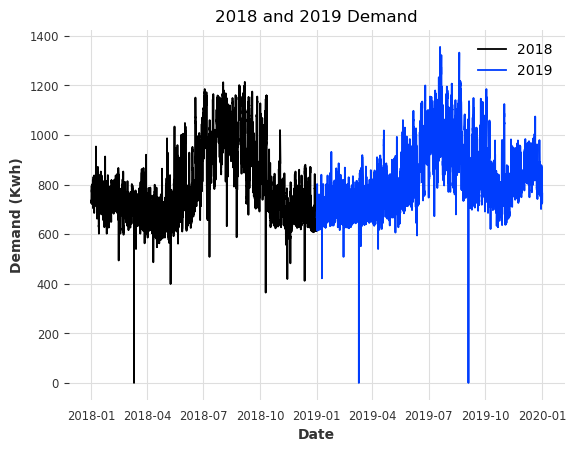

In [9]:
demand_2018 = demand_unpivoted[(demand_unpivoted['year']==2018)]['demand']
demand_2019 = demand_unpivoted[(demand_unpivoted['year']!=2018)]['demand']
_ = plt.plot(demand_2018, label='2018')
_ = plt.plot(demand_2019, label='2019')
_ = plt.title('2018 and 2019 Demand')
_ = plt.legend()
_ = plt.xlabel('Date')
_ = plt.ylabel('Demand (Kwh)')

In [16]:
#Choose breakpoint
break_date = datetime(2019,10,1)
demand_2018_prophet = demand_unpivoted[demand_unpivoted['Date'] < break_date][['demand']].reset_index()
demand_2018_prophet.columns = ['ds','y']
demand_2019_prophet = demand_unpivoted[demand_unpivoted['Date'] >= break_date][['demand']].reset_index()
demand_2019_prophet.columns = ['ds','y']
demand_2018_prophet.tail()

,ds,y
61243,2019-09-30 22:45:00,753.12
61244,2019-09-30 23:00:00,748.80
61245,2019-09-30 23:15:00,747.36
61246,2019-09-30 23:30:00,745.92
61247,2019-09-30 23:45:00,744.48


In [27]:
model = Prophet(weekly_seasonality=False)
# _ = model.add_seasonality(name='daily', period=96, fourier_order=5)
_ = model.add_seasonality(name='monthly', period=96*30.25, fourier_order=5)
# _ = model.add_seasonality(name='yearly', period=96*365, fourier_order=5)
# fit the model
_ = model.fit(demand_2018_prophet);
forecast = model.predict(demand_2019_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/opt/anaconda3/envs/grid-opt/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -402.964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        146824     0.0936962        208891           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        148888    0.00484141       15824.5           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        149172    0.00237644       7811.34      0.1537           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        149267     0.0473819       22872.8           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        149481    0.00207836       5510.23      0.3239      0.3239      556   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/anaconda3/envs/grid-opt/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/grid-opt/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


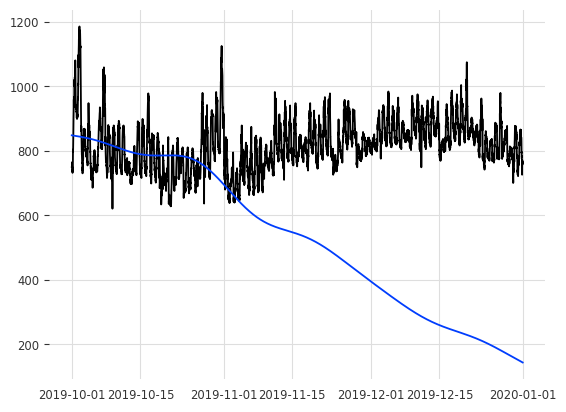

In [25]:
_ = plt.plot(demand_2019_prophet['ds'], demand_2019_prophet['y'])
_ = plt.plot(forecast['ds'], forecast['yhat'])

In [22]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(forecast['yhat'], demand_2019_prophet['y']))

179.28155337833627

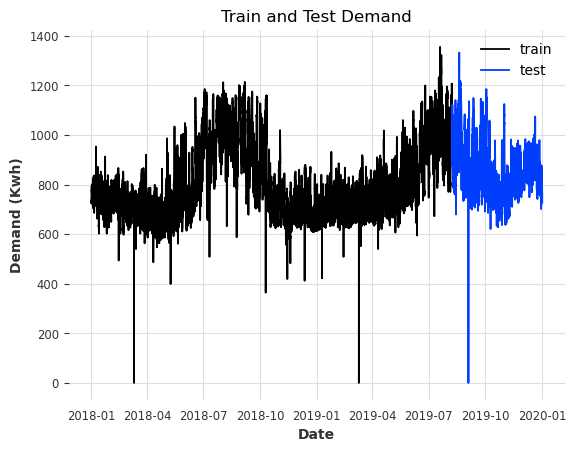

In [8]:
_ = plt.plot(train, label='train')
_ = plt.plot(test, label='test')
_ = plt.title('Train and Test Demand')
_ = plt.legend()
_ = plt.xlabel('Date')
_ = plt.ylabel('Demand (Kwh)')

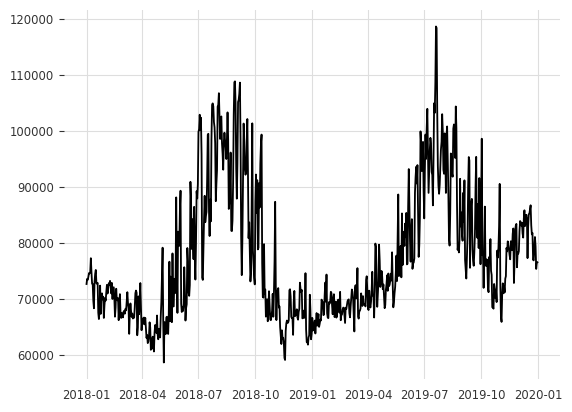

In [9]:
explore_daily = demand_unpivoted.groupby(demand_unpivoted['Date']).sum()
plt.plot(explore_daily.index, explore_daily['demand'])dd

In [10]:
_ = plot_acf(demand_2018)

AttributeError: 'Series' object has no attribute '_assert_univariate'

/opt/anaconda3/envs/grid-opt/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


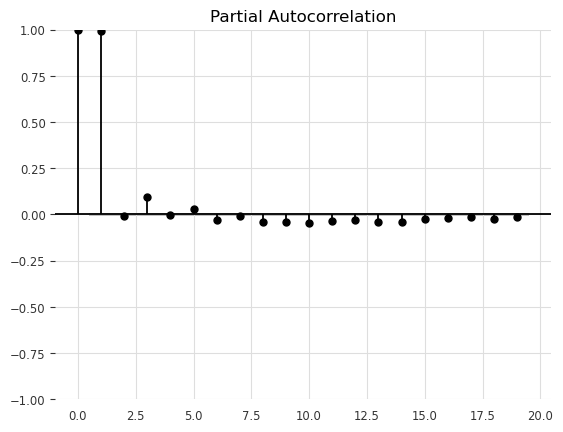

In [ ]:
_ = plot_pacf(demand_2018, lags=np.arange(20))
#Peaks at lag 2, assume AR(2) process

In [ ]:
adfuller(demand_2018)
#p-value close to zero so can reject the null hypothesis that time series is non-stationary

(-5.256740856396988,
 6.726156303386045e-06,
 52,
 34987,
 {'1%': -3.430536920280192,
  '5%': -2.861622614143799,
  '10%': -2.5668139729124237},
 283768.69607469504)

In [ ]:
#explore seasonality and stationarity
n_diffs_d = arima.ndiffs(demand_2018, max_d=5)
n_diffs_D = arima.nsdiffs(demand_2019, m=96)
print('d is ', n_diffs_d)
print('D is ', n_diffs_D)

d is  1
D is  0


In [ ]:
with StepwiseContext(max_dur=15):
    #Add a daily seasonal pattern (24 hours in a day and 4 15-minute intervals in each hour = 96 periods per day)
    arima_model = arima.auto_arima(train, d=1, seasonal=True, m=94, stepwise=True, max_p=6, max_q=6, max_P=6, max_Q=6, maxiter=30)

: 

: 

In [72]:
arima_model = arima.ARIMA([0,1,5])
arima_model.fit(demand_2018)

ARIMA(order=[0, 1, 5])

In [73]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                35040
Model:               SARIMAX(0, 1, 5)   Log Likelihood             -142760.225
Date:                Tue, 06 Dec 2022   AIC                         285534.450
Time:                        09:31:57   BIC                         285593.700
Sample:                    01-01-2018   HQIC                        285553.322
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0020      0.078     -0.026      0.980      -0.156       0.152
ma.L1          0.0073      0.001      7.172      0.000       0.005       0.009
ma.L2         -0.1030      0.001    -82.260      0.000      -0.105      -0.101
ma.L3         -0.0003      0.002     -0.185      0.853      -0.004       0.003
ma.L4         -0.0200      0.001    -31.348      0.000      -0.021      -0.019
ma.L5          0.0352      0.003     13.565      0.000       0.030       0.040
sigma2       202.4284      0.154   1312.557      0.000     202.126     202.731
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):         163371910.74
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -1.56
Prob(H) (two-sided):                  0.08   Kurtosis:                       337.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
preds = arima_model.predict(n_periods = len(demand_2019))

In [75]:
np.sqrt(np.mean((preds-demand_2019)**2))

230.905587845225

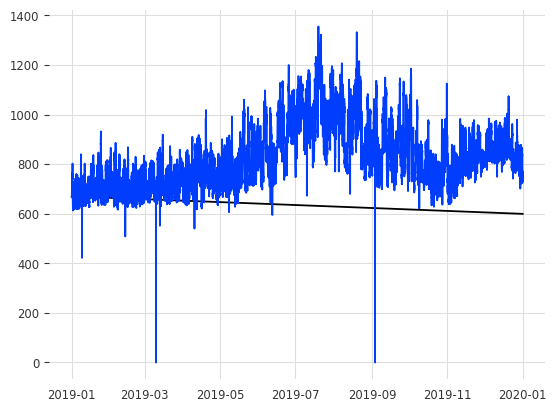

In [76]:
plt.plot(preds)
plt.plot(demand_2019)

In [27]:
forecasted_demand_2019 = pd.DataFrame(arima_model.predict(n_periods = len(test)), columns=['demand'])
forecasted_demand_2019.index = test.index
forecasted_demand_2019.head()

,demand
timestamp,
2019-08-08 00:15:00,925.196903
2019-08-08 00:30:00,924.580224
2019-08-08 00:45:00,924.889192
2019-08-08 01:00:00,924.705549
2019-08-08 01:15:00,924.813220


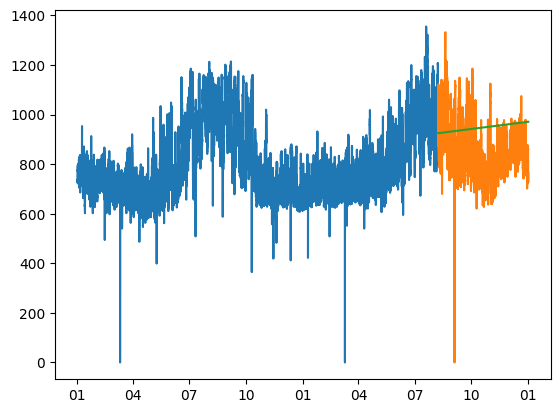

In [28]:
plt.plot(train, label = '2018 actual demand')
plt.plot(test, label = '2019 actual demand')
plt.plot(forecasted_demand_2019, label = '2019 forecasted demand')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))

## Neural Network Model

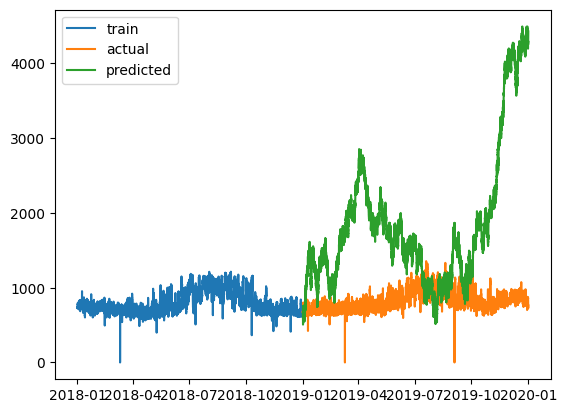

In [58]:
ets = ExponentialSmoothing(demand_2018, seasonal_periods=96, freq='15T').fit()
test_df = ets.simulate(len(demand_2019))
plt.plot(demand_2018, label='train')
plt.plot(demand_2019, label='actual')
plt.plot(test_df, label='predicted')
plt.legend()

In [39]:
check_seasonality(TimeSeries.from_series(demand_2018), max_lag=96*365)

(True, 94)

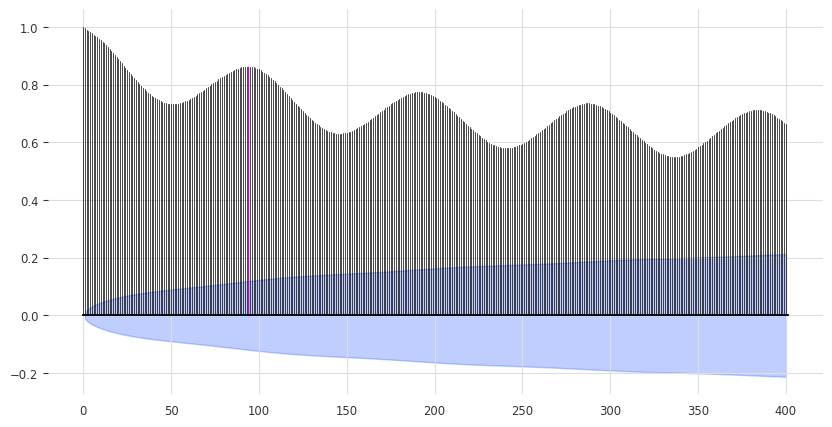

In [42]:
plot_acf(TimeSeries.from_series(demand_2018), 94, max_lag=400)

In [12]:
trf = Scaler() 
# fit the transformer to the training dataset
train_trf = trf.fit_transform(TimeSeries.from_series(demand_2018))
test_trf = trf.transform(TimeSeries.from_series(demand_2019))
ts_trf = trf.transform(TimeSeries.from_series(demand_unpivoted['demand']))

In [13]:
month_series = TimeSeries.from_series(demand_unpivoted[demand_unpivoted['year'] == 2018]['month'])
month_series = Scaler().fit_transform(month_series)
day_series = TimeSeries.from_series(demand_unpivoted[demand_unpivoted['year'] == 2018]['day'])
day_series = Scaler().fit_transform(day_series)
covariates_train = month_series.stack(day_series)

month_series_test = TimeSeries.from_series(demand_unpivoted[demand_unpivoted['year'] == 2019]['month'])
month_series_test = Scaler().fit_transform(month_series_test)
day_series_test = TimeSeries.from_series(demand_unpivoted[demand_unpivoted['year'] == 2019]['day'])
day_series_test = Scaler().fit_transform(day_series_test)
covariates_test = month_series_test.stack(day_series_test)


month_series = TimeSeries.from_series(demand_unpivoted['month'])
month_series = Scaler().fit_transform(month_series)
day_series = TimeSeries.from_series(demand_unpivoted['day'])
day_series = Scaler().fit_transform(day_series)
covariates = month_series.stack(day_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('2018-12-31 00:30:00'))

In [15]:

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper]}

In [16]:
model_RNN = RNNModel(
        model='LSTM',
        model_name='LSTM' + str(" RNN"),
        input_chunk_length=94,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=100,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True, pl_trainer_kwargs=pl_trainer_kwargs)
res = model_RNN.fit(train_trf,
             future_covariates=covariates_train,
             val_series=test_trf,
             val_future_covariates=covariates_test,
             verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.0 K 
4 | V             | Linear           | 21    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.016     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 4378/4378 [00:58<00:00, 74.38it/s, loss=0.000132, v_num=logs, train_loss=0.000115, val_loss=0.000168]


In [17]:
preds = model_RNN.predict(len(test_trf), future_covariates = cov_val)

Predicting: 2189it [00:10, ?it/s]


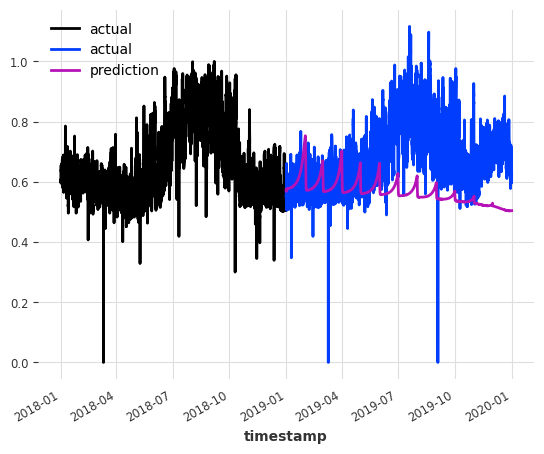

In [19]:
train_trf.plot(label='actual')
test_trf.plot(label='actual')
preds.plot(label='prediction')

## GRU

In [18]:
model_RNN_2 = RNNModel(
        model='RNN',
        model_name='RNN' + str(" RNN"),
        input_chunk_length=94,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=100,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True, pl_trainer_kwargs=pl_trainer_kwargs)
res_2 = model_RNN_2.fit(train_trf,
             future_covariates=covariates_train,
             val_series=test_trf,
             val_future_covariates=covariates_test,
             verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 500   
4 | V             | Linear           | 21    
---------------------------------------------------
521       Trainable params
0         Non-trainable params
521       Total params
0.004     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 4378/4378 [00:41<00:00, 105.46it/s, loss=0.000232, v_num=logs, train_loss=6.05e-5, val_loss=0.000174]


Predicting: 2189it [00:04, ?it/s]


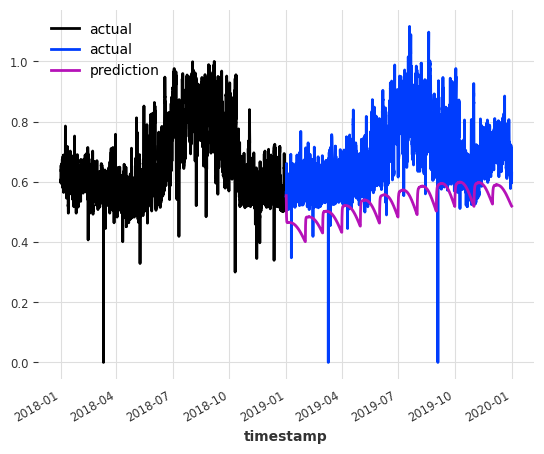

In [20]:
preds = model_RNN_2.predict(len(test_trf), future_covariates = cov_val)
train_trf.plot(label='actual')
test_trf.plot(label='actual')
preds.plot(label='prediction')

In [18]:
model_RNN_3 = RNNModel(
        model='GRU',
        model_name='GRU' + str(" RNN"),
        input_chunk_length=94,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=100,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True, pl_trainer_kwargs=pl_trainer_kwargs)
res_3 = model_RNN_3.fit(train_trf,
             future_covariates=covariates_train,
             val_series=test_trf,
             val_future_covariates=covariates_test,
             verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 1.5 K 
4 | V             | Linear           | 21    
---------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.012     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 4378/4378 [00:55<00:00, 78.60it/s, loss=0.000103, v_num=logs, train_loss=5.36e-5, val_loss=0.000176] 


Predicting: 2189it [00:05, ?it/s]


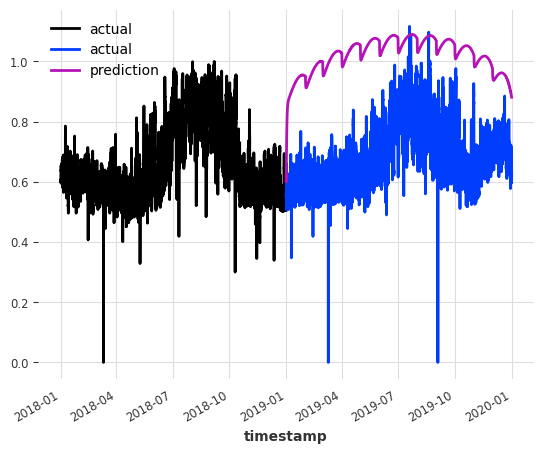

In [19]:
preds = model_RNN_3.predict(len(test_trf), future_covariates = cov_val)
train_trf.plot(label='actual')
test_trf.plot(label='actual')
preds.plot(label='prediction')

## Incorporate temperature data

In [21]:
#Import temperature dataset
temp = xr.open_dataset('./data/ERA5_2m_temp_nyc.nc')
temp

<xarray.Dataset>
Dimensions:    (longitude: 9, latitude: 9, time: 17520)
Coordinates:
  * longitude  (longitude) float32 -75.0 -74.75 -74.5 ... -73.5 -73.25 -73.0
  * latitude   (latitude) float32 42.0 41.75 41.5 41.25 ... 40.5 40.25 40.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2019-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-28 23:11:00 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [24]:
# find the mean temperature across the area
temps = temp.t2m.mean(dim=['latitude','longitude'])
temps

<xarray.DataArray 't2m' (time: 17520)>
array([261.01672, 260.69812, 260.44562, ..., 278.8514 , 277.88977,
       277.87012], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2019-12-31T23:00:00

In [36]:
#Extract the time index
times = np.array(temp.time)
times

array(['2018-01-01T00:00:00.000000000', '2018-01-01T01:00:00.000000000',
       '2018-01-01T02:00:00.000000000', ...,
       '2019-12-31T21:00:00.000000000', '2019-12-31T22:00:00.000000000',
       '2019-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [37]:
#Make into a pandas series and index by time
temps = pd.Series(temps, index=times)
temps

2018-01-01 00:00:00    261.016724
2018-01-01 01:00:00    260.698120
2018-01-01 02:00:00    260.445618
2018-01-01 03:00:00    260.071869
2018-01-01 04:00:00    259.978271
                          ...    
2019-12-31 19:00:00    278.303864
2019-12-31 20:00:00    278.656433
2019-12-31 21:00:00    278.851410
2019-12-31 22:00:00    277.889771
2019-12-31 23:00:00    277.870117
Length: 17520, dtype: float32

In [49]:
#Need to transform data into 15 minute increments so the periods match with the demand data
#iterate each hour value 4 times to account for the 4 15 minute periods in each hour
temp_15min = list(itertools.chain(*[np.tile(item,4) for item in temps]))

In [50]:
#confirm the length of the temperatures matches with demand
if len(temp_15min) == len(demand_unpivoted):
    print('temp_15min matches demand length')

temp_15min matches demand length


In [51]:
#Add in the time_15min as the index for the temperatures
temp_15min = pd.Series(temp_15min, index = demand_unpivoted.index)

In [52]:
temp_15min

timestamp
2018-01-01 00:15:00    261.016724
2018-01-01 00:30:00    261.016724
2018-01-01 00:45:00    261.016724
2018-01-01 01:00:00    261.016724
2018-01-01 01:15:00    260.698120
                          ...    
2019-12-31 23:00:00    277.889771
2019-12-31 23:15:00    277.870117
2019-12-31 23:30:00    277.870117
2019-12-31 23:45:00    277.870117
2020-01-01 00:00:00    277.870117
Length: 70080, dtype: float64

In [67]:
trf = Scaler() 
# fit the transformer to the training dataset
train_trf = trf.fit_transform(TimeSeries.from_series(demand_2018))
test_trf = trf.transform(TimeSeries.from_series(demand_2019))
ts_trf = trf.transform(TimeSeries.from_series(demand_unpivoted['demand']))

# month_series = TimeSeries.from_series(demand_unpivoted[demand_unpivoted['year'] == 2018]['month'])
# month_series = Scaler().fit_transform(month_series)
# day_series = TimeSeries.from_series(demand_unpivoted[demand_unpivoted['year'] == 2018]['day'])
# day_series = Scaler().fit_transform(day_series)
# covariates_train = month_series.stack(day_series)

# month_series_test = TimeSeries.from_series(demand_unpivoted[demand_unpivoted['year'] == 2019]['month'])
# month_series_test = Scaler().fit_transform(month_series_test)
# day_series_test = TimeSeries.from_series(demand_unpivoted[demand_unpivoted['year'] == 2019]['day'])
# day_series_test = Scaler().fit_transform(day_series_test)
# covariates_test = month_series_test.stack(day_series_test)


month_series = TimeSeries.from_series(demand_unpivoted['month'])
month_series = Scaler().fit_transform(month_series)
day_series = TimeSeries.from_series(demand_unpivoted['day'])
day_series = Scaler().fit_transform(day_series)
temp_series = TimeSeries.from_series(temp_15min)
temp_series = Scaler().fit_transform(temp_series)
covariates = month_series.stack(day_series).stack(temp_series)
cov_train, cov_test = covariates.split_after(pd.Timestamp('2018-12-31 00:30:00'))

In [62]:
# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper]}

In [63]:
model_RNN = RNNModel(
        model='LSTM',
        model_name='LSTM' + str(" RNN"),
        input_chunk_length=94,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=100,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True, pl_trainer_kwargs=pl_trainer_kwargs)
res = model_RNN.fit(train_trf,
             future_covariates=cov_train,
             val_series=test_trf,
             val_future_covariates=cov_test,
             verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.1 K 
4 | V             | Linear           | 21    
---------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.017     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 4378/4378 [00:46<00:00, 93.81it/s, loss=0.000128, v_num=logs, train_loss=7.77e-5, val_loss=0.000181] 


Predicting: 2189it [00:08, ?it/s]


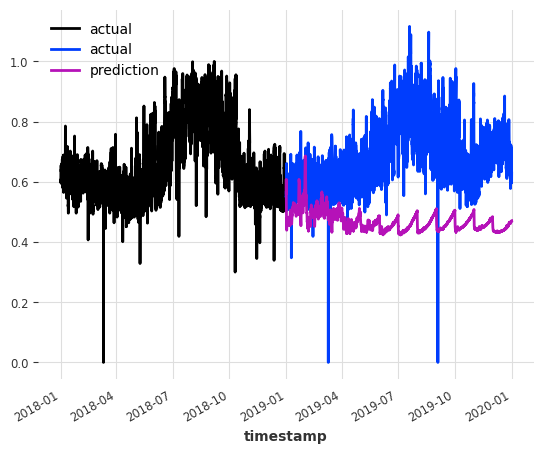

In [68]:
preds = model_RNN.predict(len(test_trf), future_covariates = cov_test)
train_trf.plot(label='actual')
test_trf.plot(label='actual')
preds.plot(label='prediction')

In [20]:
demand_unpivoted.to_csv('./data/demand_unpivoted.csv')